# Import libraries and set random seed

In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model
from graph_deep_decoder import utils

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Creating random SBM graph

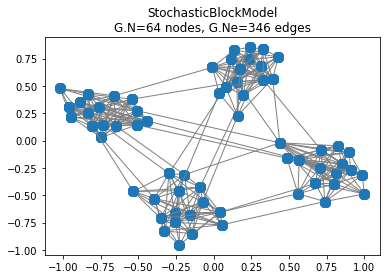

In [2]:
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64  # 256  # 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT

if Gs['N'] >= 256:
    Gs['p'] = 0.25
    Gs['q'] = 0.1*Gs['k']/Gs['N'] # 0.003
else:
    Gs['p'] = 0.7  # 0.7
    Gs['q'] = 0.015  # 0.004  # 0.015

    #Gs['q'] = [[0, 0.0075, 0, 0.0],
#           [0.0075, 0, 0.004, 0.0025],
#           [0, 0.004, 0, 0.005],
#           [0, 0.0025, 0.005, 0]]

G = ds.create_graph(Gs, SEED)

A = G.W.todense()
L = G.L.todense()
G.plot()

# Create graph filter

In [3]:
K = 3
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coeefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
x_dw.to_unit_norm()
H = x_dw.H

# H = x_dw.H/np.linalg.norm(x_dw.H)


Filter coeefs: [0.29399155 0.38311672 0.32289173]


# Analyze Jacobian

In [4]:
fts = 150  # 300  # 600
dec = GraphDecoder(fts, H)
dec_copy = copy.deepcopy(dec)
model = Model(dec_copy, epochs=1)
model.fit(x_dw.x)

JJ_an = dec.analytical_squared_jacobian()
JJ_aut = model.arch.autograd_squared_jacobian()

t1 = time.time()
Sigmas_an, U_an = utils.ordered_eig(JJ_an)
Sigmas_aut, U_aut = utils.ordered_eig(JJ_aut)
print('Time for computing eig:', time.time()-t1)

Time for computing eig: 0.002991914749145508


## Autograd Jacobian eigenvectors/eigenvalues

Text(0.5,1,'Eigvalues JJ^T')

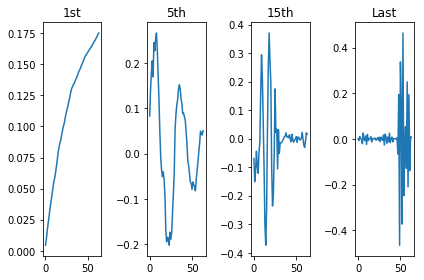

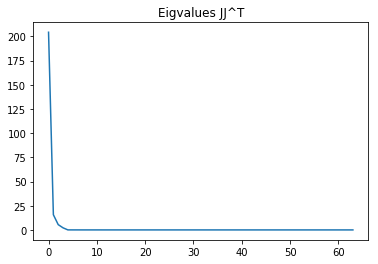

In [5]:
# Autogradient Jacobians eigendecomposition
plt.figure()
plt.subplot(141)
plt.plot(U_aut[:,0])
plt.title('1st')
plt.subplot(142)
plt.plot(U_aut[:,4])
plt.title('5th')
plt.subplot(143)
plt.plot(U_aut[:,14])
plt.title('15th')
plt.subplot(144)
plt.plot(U_aut[:,-1])
plt.title('Last')
plt.tight_layout()

plt.figure()
plt.plot(Sigmas_aut)
plt.title('Eigvalues JJ^T')

## Analytical Jacobian eigenvectors/eigenvalues

Text(0.5,1,'Eigvalues JJ^T')

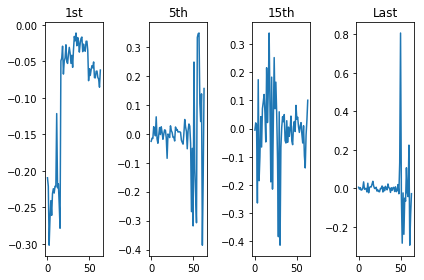

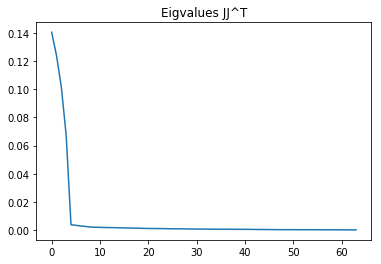

In [6]:
# Analytical Jacobians eigendecomposition
plt.figure()
plt.subplot(141)
plt.plot(U_an[:,0])
plt.title('1st')
plt.subplot(142)
plt.plot(U_an[:,4])
plt.title('5th')
plt.subplot(143)
plt.plot(U_an[:,14])
plt.title('15th')
plt.subplot(144)
plt.plot(U_an[:,-1])
plt.title('Last')
plt.tight_layout()

plt.figure()
plt.plot(Sigmas_an)
plt.title('Eigvalues JJ^T')


## Smoothness on L

Eigv 1: Smoothness over L: 0.5969313382744731
Eigv 2: Smoothness over L: 0.7988277996299854
Eigv 5: Smoothness over L: 15.317637730831688
Eigv 15: Smoothness over L: 12.825931835166704
Eigv last: Smoothness over L: 10.711966608139672


Text(0.5,0,'Eigenvectors')

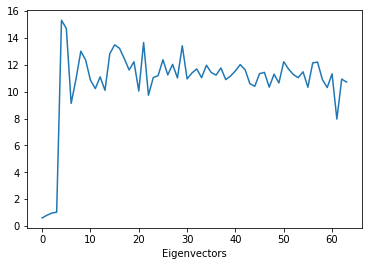

In [7]:
smoothness = np.diag(U_an.T.dot(L).dot(U_an))
print('Eigv 1: Smoothness over L:', smoothness[0])
print('Eigv 2: Smoothness over L:', smoothness[1])
print('Eigv 5: Smoothness over L:', smoothness[4])
print('Eigv 15: Smoothness over L:', smoothness[14])
print('Eigv last: Smoothness over L:', smoothness[-1])

plt.figure()
plt.plot(smoothness)
plt.xlabel('Eigenvectors')

## Compare with eigendecomposition of A

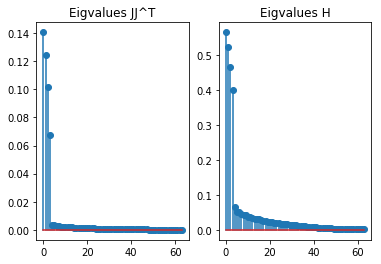

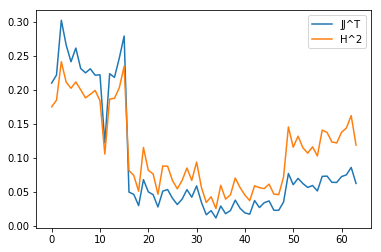

In [8]:
eigval_H, V_H = utils.ordered_eig(H)

U_an = utils.choose_eig_sign(U_an, V_H)

plt.subplot(121)
plt.stem(Sigmas_an)
plt.title('Eigvalues JJ^T')
plt.subplot(122)
plt.stem(eigval_H)
plt.title('Eigvalues H')

plt.figure()
plt.plot(U_an[:,0])
plt.plot(V_H[:,0])
plt.legend(['JJ^T','H^2'])

## Sampled Expected Squared Jacobian

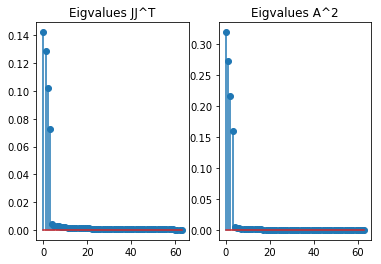

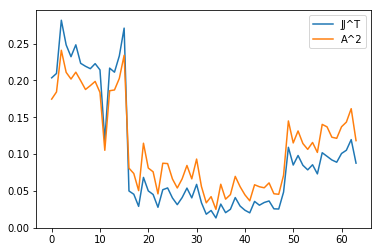

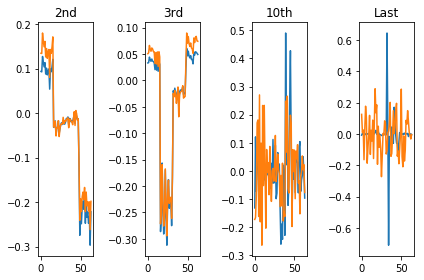

In [9]:
samples = 10000
Exp_JJ = np.zeros((G.N, G.N))
for i in range(samples):
    Exp_JJ += GraphDecoder(fts, H).analytical_squared_jacobian()/samples

Exp_S, Exp_U = utils.ordered_eig(Exp_JJ)
Exp_U = utils.choose_eig_sign(Exp_U, V_H)

plt.subplot(121)
plt.stem(Exp_S)
plt.title('Eigvalues JJ^T')
plt.subplot(122)
plt.stem(eigval_H**2)
plt.title('Eigvalues A^2')

plt.figure()
plt.plot(Exp_U[:, 0])
plt.plot(V_H[:, 0])
plt.legend(['JJ^T','A^2'])

plt.figure()
plt.subplot(141)
plt.plot(Exp_U[:, 1])
plt.plot(V_H[:,1])
plt.title('2nd')
plt.subplot(142)
plt.plot(Exp_U[:, 2])
plt.plot(V_H[:,2])
plt.title('3rd')
plt.subplot(143)
plt.plot(Exp_U[:, 9])
plt.plot(V_H[:,9])
plt.title('10th')
plt.subplot(144)
plt.plot(Exp_U[:, -1])
plt.plot(V_H[:, -1])
plt.title('Last')
plt.tight_layout()

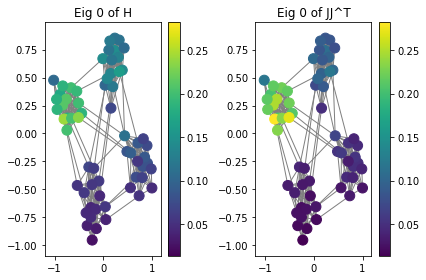

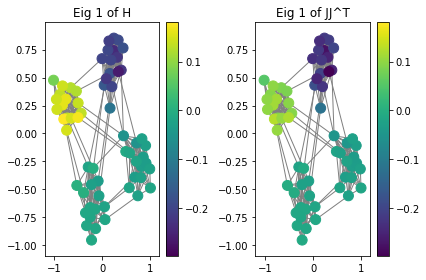

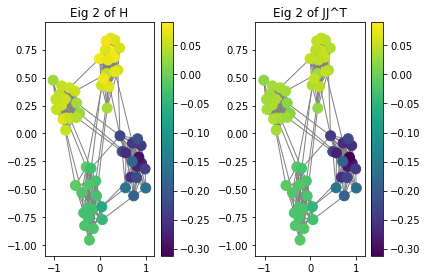

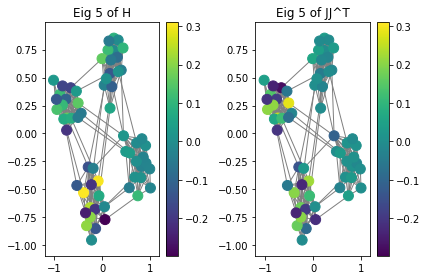

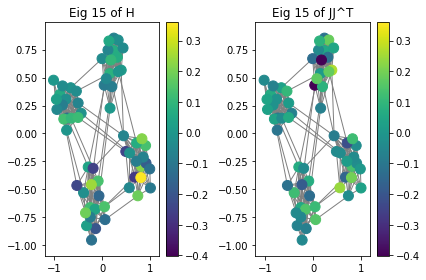

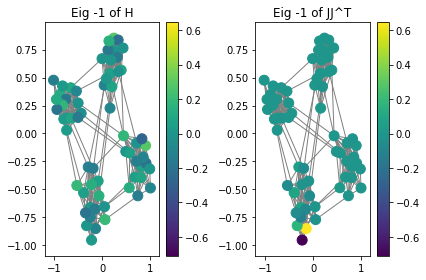

In [10]:
eig_inds = [0, 1, 2, 5, 15, -1]
for eig_ind in eig_inds:
    eig_H = V_H[:, eig_ind]
    eig_JJ = Exp_U[:, eig_ind]
    
    lims = [np.min([eig_H, eig_JJ]), np.max([eig_H, eig_JJ])]
    # lims = [-np.inf, np.inf]
    
    plt.figure()
    ax = plt.subplot(121)
    G.plot_signal(eig_H, ax=ax, limits=lims)
    plt.title('Eig {} of H'.format(eig_ind))
    ax = plt.subplot(122)
    G.plot_signal(eig_JJ, ax=ax, limits=lims)
    plt.title('Eig {} of JJ^T'.format(eig_ind))
    plt.tight_layout()


## Inner product of Jaconbian and A eigenvectors

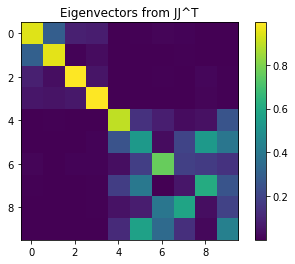

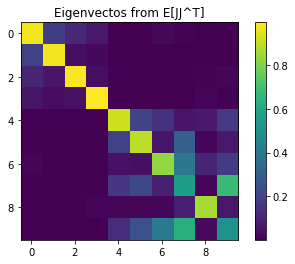

In [11]:
k = 10
V_H_k = V_H[:,:k]
U_an_k = U_an[:,:k]
U_exp_k = Exp_U[:,:k]

plt.figure()
plt.imshow(abs(V_H_k.T.dot(U_an_k)))
plt.title('Eigenvectors from JJ^T')
plt.colorbar()
plt.figure()
plt.imshow(abs(V_H_k.T.dot(U_exp_k)))
plt.title('Eigenvectos from E[JJ^T]')
plt.colorbar()


## Analytical Expected Jacobian

1.0000000000000009
[39.76257489  6.60900887  6.2938966   5.88451124  0.32613253  0.28081213
  0.261195    0.21673091  0.20107414  0.18563086]
[6.60980329 6.29426064 5.88662804 0.43514294 0.31967169 0.26230097
 0.22568035 0.21126546 0.19432809 0.18439984]


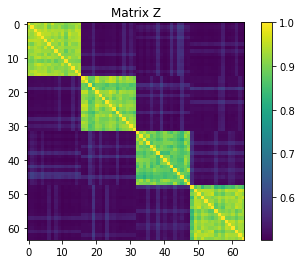

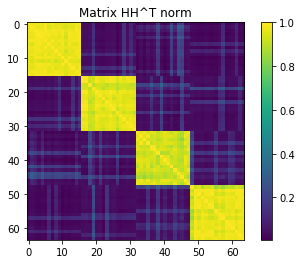

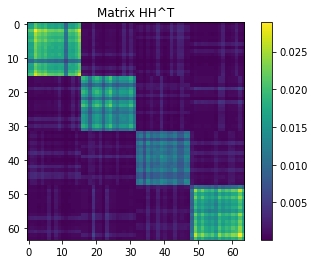

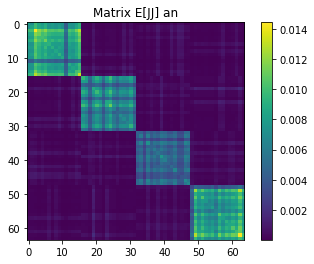

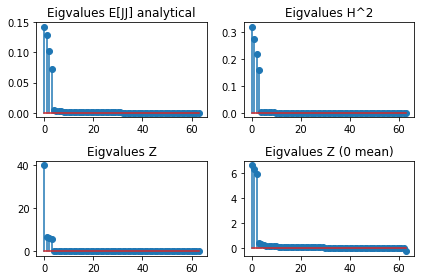

In [12]:
# Compute E[JJ]
norm = 'row'
only_H2_norm = False

H2 = H.dot(H.T)

if norm == 'Fro':
    H_norm = H/np.linalg.norm(H)
    H2_norm = H_norm.dot(H_norm.T)
elif norm == 'max':
    H2_norm = H2/np.max(H2)
else:
    H_norm = H/np.linalg.norm(H, axis=0)
    H2_norm = H_norm.T.dot(H_norm)
    print(np.max(H2_norm))
    H2_norm[H2_norm>1]=1

if only_H2_norm:
    H2 = H2_norm

Z = 1-np.arccos(H2_norm)/np.pi    
Z_0 = Z - np.mean(Z)
E_JJ_an = 0.5*Z*(H2)

# Get eigendecomposition
L_H, V_H = utils.ordered_eig(H)
L_Z, V_Z = utils.ordered_eig(Z)
V_Z = utils.choose_eig_sign(V_Z, V_H)
L_Z0, V_Z0 = utils.ordered_eig(Z_0)
V_Z0 = utils.choose_eig_sign(V_Z0, V_H)
L_E_JJ_an, V_E_JJ_an = utils.ordered_eig(E_JJ_an)
V_E_JJ_an = utils.choose_eig_sign(V_E_JJ_an, V_H)

# Plot matrices
plt.figure()
plt.imshow(Z)
plt.colorbar()
plt.title('Matrix Z')
plt.figure()
plt.imshow(H2_norm)
plt.colorbar()
plt.title('Matrix HH^T norm')
plt.figure()
plt.imshow(H.dot(H))
plt.colorbar()
plt.title('Matrix HH^T')
plt.figure()
plt.imshow(E_JJ_an)
plt.colorbar()
plt.title('Matrix E[JJ] an')

# Compare eigenvalues
plt.figure()
plt.subplot(221)
plt.stem(L_E_JJ_an)
plt.title('Eigvalues E[JJ] analytical')
plt.subplot(222)
plt.stem(L_H**2)
plt.title('Eigvalues H^2')
plt.subplot(223)
plt.stem(L_Z)
plt.title('Eigvalues Z')
plt.subplot(224)
plt.stem(L_Z0)
plt.title('Eigvalues Z (0 mean)')
plt.tight_layout()
print(L_Z[:10])
print(L_Z0[:10])

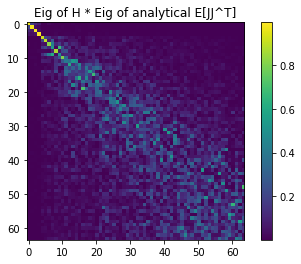

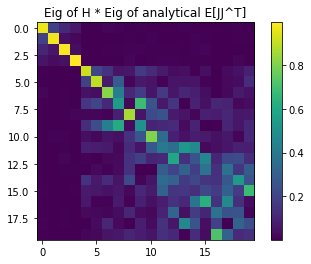

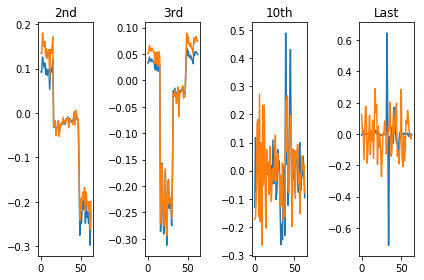

In [13]:
# Check orthogonality 
plt.figure()
plt.imshow(abs(V_H.T.dot(V_E_JJ_an)))
plt.colorbar()
plt.title('Eig of H * Eig of analytical E[JJ^T]')

k = 20
plt.figure()
plt.imshow(abs(V_H[:,:k].T.dot(V_E_JJ_an[:,:k])))
plt.colorbar()
plt.title('Eig of H * Eig of analytical E[JJ^T]')

# Plot eigenvectors
plt.figure()
plt.subplot(141)
plt.plot(V_E_JJ_an[:, 1])
plt.plot(V_H[:,1])
plt.title('2nd')
plt.subplot(142)
plt.plot(V_E_JJ_an[:, 2])
plt.plot(V_H[:,2])
plt.title('3rd')
plt.subplot(143)
plt.plot(V_E_JJ_an[:, 9])
plt.plot(V_H[:,9])
plt.title('10th')
plt.subplot(144)
plt.plot(V_E_JJ_an[:, -1])
plt.plot(V_H[:, -1])
plt.title('Last')
plt.tight_layout()

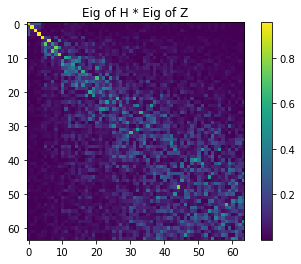

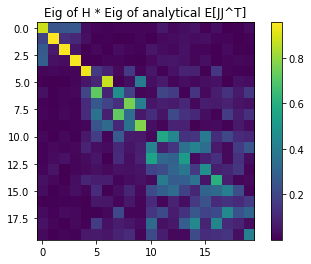

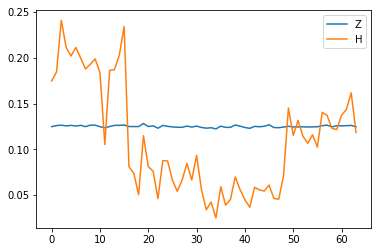

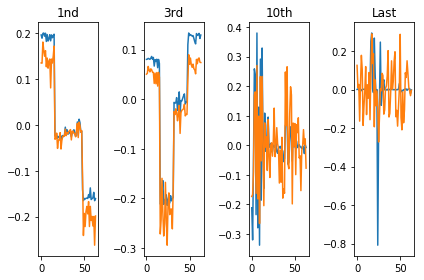

In [14]:
# Check orthogonality 
plt.figure()
plt.imshow(abs(V_H.T.dot(V_Z)))
plt.colorbar()
plt.title('Eig of H * Eig of Z')

k = 20
plt.figure()
plt.imshow(abs(V_H[:,:k].T.dot(V_Z[:,:k])))
plt.colorbar()
plt.title('Eig of H * Eig of analytical E[JJ^T]')

# Plot eigenvectors
plt.figure()
plt.plot(V_Z[:,0])
plt.plot(V_H[:,0])
plt.legend(['Z','H'])

plt.figure()
plt.subplot(141)
plt.plot(V_Z[:, 1])
plt.plot(V_H[:,1])
plt.title('1nd')
plt.subplot(142)
plt.plot(V_Z[:, 2])
plt.plot(V_H[:,2])
plt.title('3rd')
plt.subplot(143)
plt.plot(V_Z[:, 9])
plt.plot(V_H[:,9])
plt.title('10th')
plt.subplot(144)
plt.plot(V_Z[:, -1])
plt.plot(V_H[:, -1])
plt.title('Last')
plt.tight_layout()

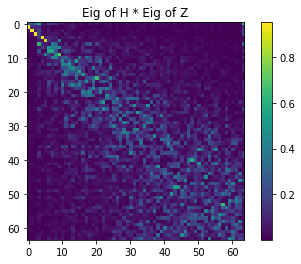

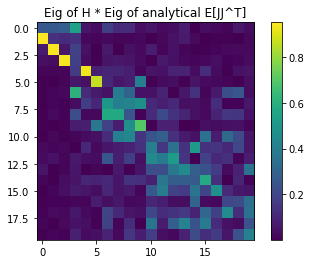

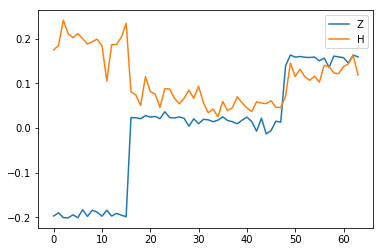

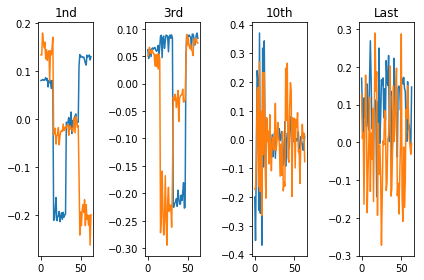

In [15]:
# Check orthogonality 
plt.figure()
plt.imshow(abs(V_H.T.dot(V_Z0)))
plt.colorbar()
plt.title('Eig of H * Eig of Z')

k = 20
plt.figure()
plt.imshow(abs(V_H[:,:k].T.dot(V_Z0[:,:k])))
plt.colorbar()
plt.title('Eig of H * Eig of analytical E[JJ^T]')

# Plot eigenvectors
plt.figure()
plt.plot(V_Z0[:,0])
plt.plot(V_H[:,0])
plt.legend(['Z','H'])

plt.figure()
plt.subplot(141)
plt.plot(V_Z0[:, 1])
plt.plot(V_H[:,1])
plt.title('1nd')
plt.subplot(142)
plt.plot(V_Z0[:, 2])
plt.plot(V_H[:,2])
plt.title('3rd')
plt.subplot(143)
plt.plot(V_Z0[:, 9])
plt.plot(V_H[:,9])
plt.title('10th')
plt.subplot(144)
plt.plot(V_Z0[:, -1])
plt.plot(V_H[:, -1])
plt.title('Last')
plt.tight_layout()

# Denoise signals

In [16]:
n_signals = 25
n_p = 0.1
epochs = 1000
lr = 0.001

err = np.zeros((3, epochs, n_signals))
for i in range(n_signals):
    dec = GraphDecoder(150, H, scale_std=.01)
    
    # Create signals
    x = G.info['node_com']/np.linalg.norm(G.info['node_com'])
    noise = np.random.randn(x.size)*np.sqrt(n_p/x.size)
    x_n = x + noise
    noise /= np.linalg.norm(noise)

    # Create models
    model_x = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_noise = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_x_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

    # Train modesls
    _, err[0, :, i], _ = model_x.fit(x, x, reduce_err=True)
    _, err[1, :, i], _ = model_noise.fit(noise, noise, reduce_err=True)
    _, err[2, :, i], _ = model_x_n.fit(x_n, x, reduce_err=True)

    # Normalize error
    # err[0, :] = err[0, :]/np.linalg.norm(x)
    # err[1, :] = err[1, :]/np.linalg.norm(noise)
    # err[2, :] = err[2, :]/np.linalg.norm(x)
    print('Signal', i, 'done')

Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done


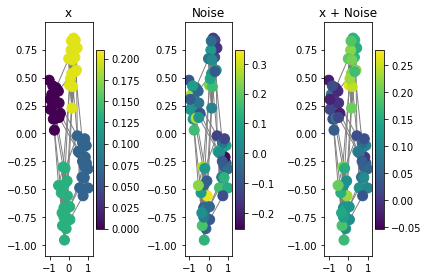

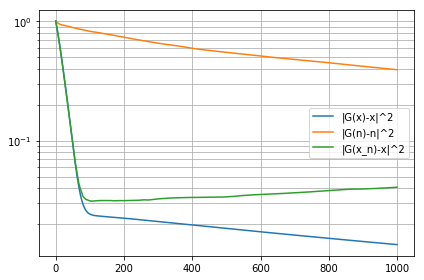

In [17]:
# Plot signals
plt.figure()
ax = plt.subplot(131)
G.plot_signal(x, ax=ax)
plt.title('x')
ax = plt.subplot(132)
G.plot_signal(noise, ax=ax)
plt.title('Noise')
ax = plt.subplot(133)
G.plot_signal(x_n, ax=ax)
plt.title('x + Noise')
plt.tight_layout()


# Plot error
err_med = np.median(err, axis=2)
plt.figure()
plt.semilogy(err_med.T)
plt.legend(['|G(x)-x|^2', '|G(n)-n|^2', '|G(x_n)-x|^2'])
plt.grid(True, which='both')
plt.tight_layout()

## Creating signals

In [18]:
plt.show()